In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import sys

matplotlib.rcParams.update({'font.size': 14})

In [2]:
input_file = 'tomtom/tomtom.tsv'

df = pd.read_csv(input_file, sep='\t', comment='#', skip_blank_lines=True)

## Identify most significant cluster alignments

In [104]:
df.sort_values(by=['Overlap', 'p-value'], ascending=[False, True], inplace=True)
df.head()

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
133,19,MA0503.1,0,0.000002,0.002759,0.005517,11,AGGCACTCAGG,AGCCACTCAAG,+
195,25,MA0073.1,5,0.000009,0.016927,0.033724,11,ACCCACCCCCC,CCCCAAACCACCCCCCCCCC,+
369,38,KLF14_DBD,0,0.000009,0.016970,0.014606,11,GGCCACTCCCC,GGCCACGCCCCCTT,+
370,38,MA0740.1,0,0.000009,0.016970,0.014606,11,GGCCACTCCCC,GGCCACGCCCCCTT,+
50,8,UP00021_1,0,0.000010,0.017498,0.034930,11,TCCCTCCCCGC,TCCCCCCCCCCCCCC,+


In [130]:
full_most_signif_align = df.loc[ (df.Overlap == 11) & (df['p-value'] <= 1e-04) ]

top_hits = 20
#most_signif_align = most_signif_align.head(20)
most_signif_align = full_most_signif_align[['Target_ID', 'p-value']].head(top_hits)
most_signif_align.index = most_signif_align['Target_ID']
most_signif_align.drop(['Target_ID'], axis=1, inplace=True)
most_signif_align['phred'] = most_signif_align['p-value'].apply(lambda x: -10*np.log(x))
most_signif_align.drop('p-value', axis=1, inplace=True)

most_signif_align.sort_values(by='phred', ascending=True, inplace=True)
most_signif_align

,phred
Target_ID,
MA0039.3,96.443377
KLF13_full,97.596349
MA0657.1,97.596349
SOX7_full_3,97.605377
MA0493.1,97.782779
MA0528.1,99.012421
MA1107.1,99.130431
MA0696.1,99.585522
ZIC1_full,99.585522


In [118]:
def plot_top_targets(input_df, xlabel, title, consensus_col='Target_consensus', color='#3182bd'):
    
    ax = input_df.plot(kind='barh', figsize=(12, 12), color=color, align='edge', width=0.25, legend=False)
    plt.xlabel(xlabel)
    plt.ylabel('Target motif ID')

    plt.title(title)

    x_max = max(input_df.iloc[:, 0])+ 0.6
    cnt = 0
    for p in ax.patches:

        cur_target_id = most_freq_df.index[cnt]
        cons_seq = df.loc[ df.Target_ID == cur_target_id, consensus_col].unique()[0]
        
        query_id = df.loc[ df.Target_ID == cur_target_id, 'Query_ID'].unique()[0]
        ax.annotate(cons_seq, (x_max, p.get_y()))
        cnt += 1
        
    plt.savefig('Most_frequent.' + consensus_col + '.pdf', bbox_inches='tight')

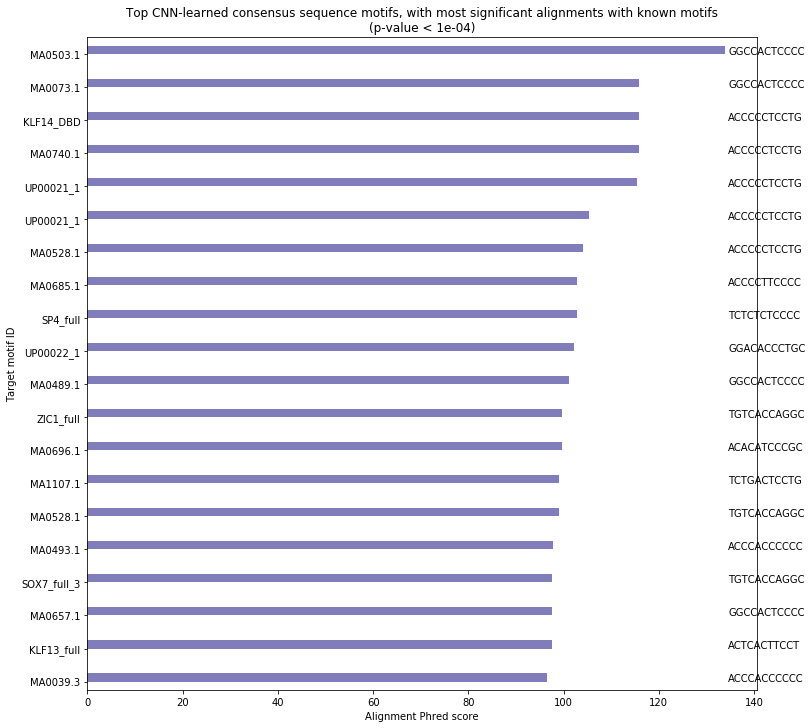

In [119]:
cur_title = 'Top CNN-learned consensus sequence motifs, with most significant alignments with known motifs\n(p-value < 1e-04)'
cur_xlabel = 'Alignment Phred score'
plot_top_targets(most_signif_align, cur_xlabel, cur_title, consensus_col='Query_consensus', color='#807dba')

## Identify most frequently aligned known motifs

In [33]:
target_ids = df['Target_ID']
target_counter = dict(Counter(target_ids))
#print(target_counter)

In [34]:
most_frequent_targets = []
freq_cutoff = 5
for target, freq in sorted(target_counter.items(), key=lambda x: x[1], reverse=True):
    
    if freq < freq_cutoff:
        break
    else:
        most_frequent_targets.append([target, freq])
        #print(target, freq)

most_frequent_targets = np.array(most_frequent_targets)

most_freq_df = pd.DataFrame({'target_id': most_frequent_targets[:, 0], 'freq': most_frequent_targets[:, 1]})
most_freq_df['freq'] = most_freq_df['freq'].astype(float)

most_freq_df.index = most_freq_df['target_id']
most_freq_df.drop(['target_id'], axis=1, inplace=True)
most_freq_df.sort_values(by='freq', ascending=True, inplace=True)

In [35]:
most_freq_df.head()

,freq
target_id,
MA0746.1,5.0
MA0489.1,5.0
MA1107.1,5.0
Creb3l2_DBD_2,5.0
SP3_DBD,5.0


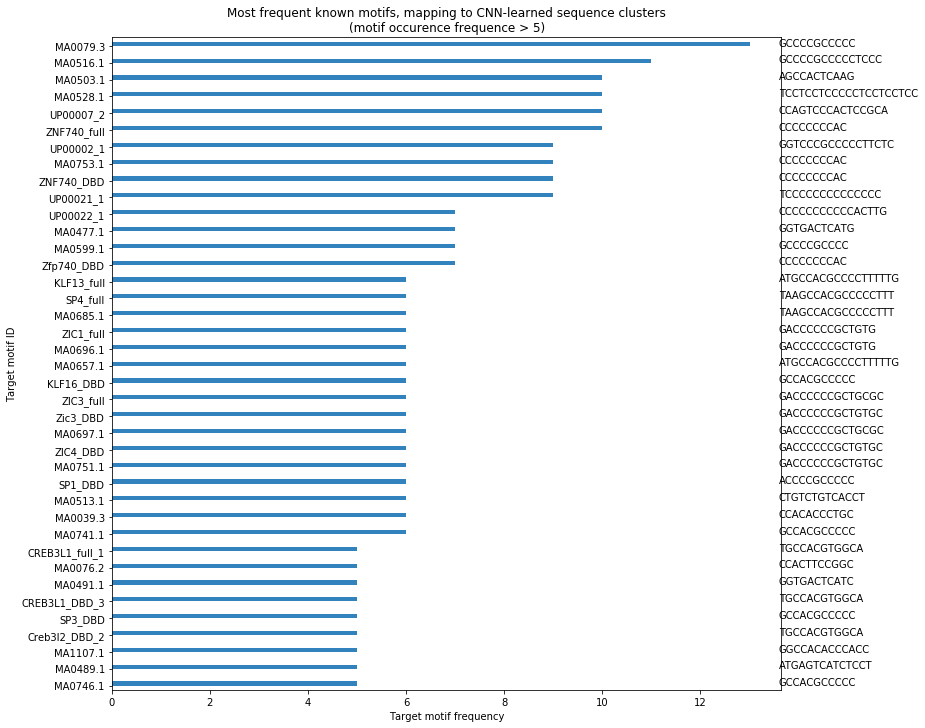

In [128]:
cur_title = 'Most frequent known motifs, mapping to CNN-learned sequence clusters\n(motif occurence frequence > 5)'
cur_xlabel = 'Target motif frequency'
plot_top_targets(most_freq_df, cur_xlabel, cur_title)

In [132]:
most_freq_and_signif_align_targets = list(set(full_most_signif_align['Target_ID'].tolist()) & set(most_freq_df.index.tolist()))
len(most_freq_and_signif_align_targets)

16

In [125]:
uniq_cons_seqs = df.loc[ df.Target_ID.isin(list(most_freq_and_signif_align_targets)), 'Target_consensus'].unique()
len(uniq_cons_seqs)

12